# Вебинар 4. Рекоммендательные системы на основе контента. Поиск похожих товаров и пользователей

---

## Комментарии к домашним заданиям

### 1. Общие

ALS
- На вход принимает только *позитивные* взаимодействия
- Прогнозирует **не** вероятность, а некоторые числа
- В ALS нельзя добавить внешние фичи
- ALS не учитывает сезонность / зависимость во времени (но это можно частично поправить - см далее)
- Можно использовать для ранжирования (как - см далее + вебинар 5)

### 2. Что на самом деле оптимизирует ALS

![als_formula.png](attachment:als_formula.png)

$x_u^T$ - user embeddings  
$y_i$ - item embeddings  
$p_{ui}$ - 0/1. 1 - если в матрице user-item эдемент > 0 (было взаимодействие)  
$c_{ui}$ - Вес ошибки = элемент матрицы user-item  
$\lambda_x$, $\lambda_y$ - коэффициенты регуляризации  

**Что делает ALS**
- Максимизирует скалярное произведение (dot product) между векторами user-item для позитивных interactions, минимизирует для негативных

**Скалярное призведение (dot product) VS косинусная схожесть (cosine similarity)**

$$dot(a, b) = a * b$$  
  
$$cos(a, b) = \frac{a * b}{||a||*||b||} = \frac{dot(a, b)}{||a||*||b||}$$

### 3. Как учитывать изменение вкусов потребителей во времени / изменение популярности товара во времени

- Летом юзеры любят мороженое, а зимой - нет
- Многие фильмы популярны во время проката в кино, затем их популярность снижается

*Что делать?*  
Ограничить давность взаимодейстий.  
Давать последним взаимодействиям больший вес:  

$$value_w = \sum_i value_i * \frac{1}{1 + \exp^{ \alpha*t}}$$

### 4. Как использовать для ранжирования (Краткое введение. Подробности - на следующем вебинаре)

**Вариант 1.**  
*As is* - ранжировать по output ALS

**Вариант 2.**
*Та же модель, другой лосс - BPR*

BPR - Bayesian Personalized Ranking loss
1. Случайная пара user - купленный им item_i = позитивная пара
2. Для того же юзера сэмплируем item_j (не купил или вес в user-item матрице ниже, у item_i из 1.) - негативная пара
3. Прогнозы модели $p_{ui}$, $p_{uj}$ --> $p_{ui} - p_{uj}$
4. loss = $\sigma(p_{ui} - p_{uj})$ - это и есть наша ошибка
5. Обновляем эмбеддинги

In [1]:
!pip install implicit

     |████████████████████████████████| 1.1 MB 5.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for implicit: filename=implicit-0.4.8-cp37-cp37m-linux_x86_64.whl size=4606549 sha256=bcb9c08417d7f519dc089e3c51e7e6616285b5712ce414bcfe1262dba1598833
  Stored in directory: /root/.cache/pip/wheels/88/e6/34/25e73cccbaf1a961154bb562a5f86123b68fdbf40e306073d6
Successfully built implicit


In [2]:
from implicit.bpr import BayesianPersonalizedRanking

Синтаксис такой же как у AlternatingLeastSquares. ML модель такая же, лосс - BPR

---

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import ItemItemRecommender  # нужен для одного трюка
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

# Функции из 1-ого вебинара
import os, sys

In [56]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list  # Тут нет [:k] !!
    try:
        recommended_list = recommended_list[:k]
    except:
        recommended_list = []
    
    flags = np.isin(bought_list, recommended_list)
    
    precision = flags.sum() / len(recommended_list)
    
    
    return precision

In [9]:
def prefilter_items(data):
    # Уберем самые популярные товары (их и так купят)
    popularity = data_train.groupby('item_id')['user_id'].nunique().reset_index() / data_train['user_id'].nunique()
    popularity.rename(columns={'user_id': 'share_unique_users'}, inplace=True)
    
    top_popular = popularity[popularity['share_unique_users'] > 0.5].item_id.tolist()
    data = data[~data['item_id'].isin(top_popular)]
    
    # Уберем самые НЕ популярные товары (их и так НЕ купят)
    top_notpopular = popularity[popularity['share_unique_users'] < 0.01].item_id.tolist()
    data = data[~data['item_id'].isin(top_notpopular)]
    
    # Уберем товары, которые не продавались за последние 12 месяцев
    
    # Уберем не интересные для рекоммендаций категории (department)
    
    # Уберем слишком дешевые товары (на них не заработаем). 1 покупка из рассылок стоит 60 руб. 
    
    # Уберем слишком дорогие товарыs
    
    # ...
    
def postfilter_items(user_id, recommednations):
    pass

In [5]:
from google.colab import drive
drive.mount('/content/drive')
root = '/content/drive/My Drive/GB/RecSys/webinar_2/'

Mounted at /content/drive


In [6]:
data = pd.read_csv(root+'transaction_data.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)


test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [7]:
item_features = pd.read_csv(root+'product.csv')
item_features.columns = [col.lower() for col in item_features.columns]
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)

item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [8]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[879517, 934369, 1115576, 1124029, 5572301, 65..."
1,3,"[823704, 834117, 840244, 913785, 917816, 93870..."


In [ ]:
n_items_before = data_train['item_id'].nunique()

In [11]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [12]:
n_items_after = data_train['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 90386 to 5001


In [13]:
user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробоват ьдругие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

user_item_matrix.head(3)

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,819255,819304,819308,819330,819518,819594,819643,819765,819840,819845,819927,819978,820082,820122,820165,820291,820301,820321,820347,820361,820486,820518,820560,820895,821025,821083,821200,821209,821219,821344,...,14025461,14043817,14043823,14043825,14043826,14050436,14050460,14050461,14077333,14106445,15452531,15452677,15452812,15506577,15511891,15596279,15596488,15596515,15629778,15716445,15716719,15717057,15741861,15777852,15778533,15831255,15926712,15926725,15926775,15926844,15926885,15926886,15926887,15926927,15927033,15927403,15927661,15927850,16809471,17105257
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [15]:
user_item_matrix = bm25_weight(user_item_matrix.T).T  # Применяется к item-user матрице ! 

In [18]:
%%time

model = AlternatingLeastSquares(factors=20, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                use_gpu=False)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: user 23.2 s, sys: 37 s, total: 1min
Wall time: 31.3 s


In [19]:
def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]],  # !!! 
                                    recalculate_user=True)]
    return res

In [20]:
%%time
    
result['bm25'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

CPU times: user 52.8 s, sys: 42.7 s, total: 1min 35s
Wall time: 49 s


In [45]:
result.apply(lambda row: precision_at_k(row['bm25'], row['actual']), axis=1).mean()

0.12405826217980837

In [22]:
result.head(2)

,user_id,actual,bm25
0,1,"[879517, 934369, 1115576, 1124029, 5572301, 65...","[1004390, 819518, 999391, 1047619, 958046]"
1,3,"[823704, 834117, 840244, 913785, 917816, 93870...","[1110244, 8090521, 8090537, 941741, 5569230]"


----

# Альтернативные способы предсказаний

### Кейс 1. Продажи товаров собственной торговой марки (СТМ)

У многих ритейлеров есть товары СТМ:
    - Азбука Вкуса - Просто Азбука
    - Ашан - Каждый день
    - ВкусВилл - ВкусВилл
    - ...
    
Как правило, у них маржинальность (~прибыль) > обычные товары.   
Как сделать так, чтобы юзеры переключились на товары СТМ? - *рекоммендации!*

*Нужно заменить те товары, которые пользователь уже покупает, на товары СТМ*

In [23]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [24]:
item_features = item_features[item_features['item_id'].isin(itemid_to_id.keys())]
item_features[item_features['brand'] == 'Private'].item_id.nunique()

1469

In [25]:
own_items = item_features[item_features['brand'] == 'Private'].\
    groupby('department')['item_id'].nunique().\
    sort_values(ascending=False)
own_items

department
GROCERY            1231
MEAT-PCKGD           74
PRODUCE              32
PASTRY               31
DELI                 27
MISC SALES TRAN      20
DRUG GM              16
KIOSK-GAS            13
SEAFOOD-PCKGD        11
MEAT                  8
NUTRITION             5
FLORAL                1
Name: item_id, dtype: int64

In [26]:
categories_with_own_items = own_items.index.tolist()

In [27]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import cm
import pickle

from scipy.spatial.distance import cdist

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns


def reduce_dims(df, dims=2, method='pca'):
    
    assert method in ['pca', 'tsne'], 'Неверно указан метод'
    
    if method=='pca':
        pca = PCA(n_components=dims)
        components = pca.fit_transform(df)
    elif method == 'tsne':
        tsne = TSNE(n_components=dims, learning_rate=250, random_state=42, n_iter=300, n_iter_without_progress=20)
        components = tsne.fit_transform(df)
    else:
        print('Error')
        
    colnames = ['component_' + str(i) for i in range(1, dims+1)]
    return pd.DataFrame(data = components, columns = colnames) 


def display_components_in_2D_space(components_df, labels='category', marker='D'):
    
    groups = components_df.groupby(labels)

    # Plot
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    for name, group in groups:
        ax.plot(group.component_1, group.component_2, 
                marker='o', ms=6,
                linestyle='',
                alpha=0.7,
                label=name)
    ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))

    plt.xlabel('component_1')
    plt.ylabel('component_2') 
    plt.show()

In [28]:
model.item_factors.shape

(5001, 20)

In [29]:
category = []

for idx in range(model.item_factors.shape[0]):

    try:
        cat = item_features.loc[item_features['item_id'] == id_to_itemid[idx], 'department'].values[0]
        category.append(cat)
    except:
        category.append('UNKNOWN')

In [ ]:
category

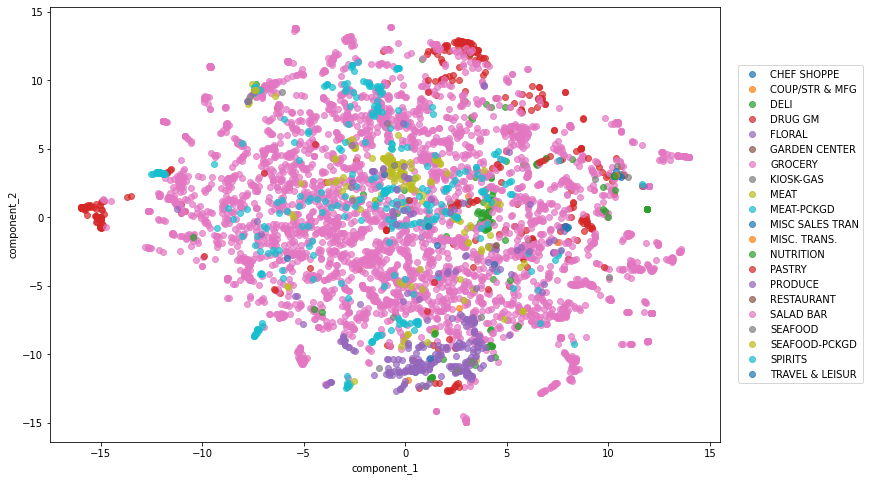

CPU times: user 41.7 s, sys: 75.9 ms, total: 41.8 s
Wall time: 22.2 s


In [31]:
%%time
item_emb_tsne = reduce_dims(model.item_factors, dims=2, method='tsne')
item_emb_tsne['category'] = category  # Добавляем категорию
item_emb_tsne['item_id'] = list(itemid_to_id.keys())
item_emb_tsne = item_emb_tsne[item_emb_tsne['category'] != 'UNKNOWN']

display_components_in_2D_space(item_emb_tsne, labels='category')

In [ ]:
item_emb_tsne_reduced = item_emb_tsne[item_emb_tsne['category'] != 'GROCERY']

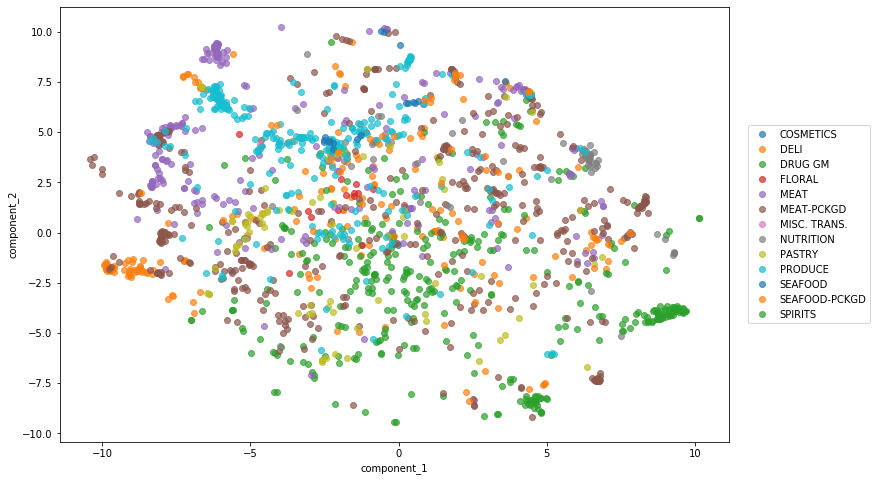

In [ ]:
display_components_in_2D_space(item_emb_tsne_reduced, labels='category')

Нарисуем все товары в катгеориях, где есть СТМ

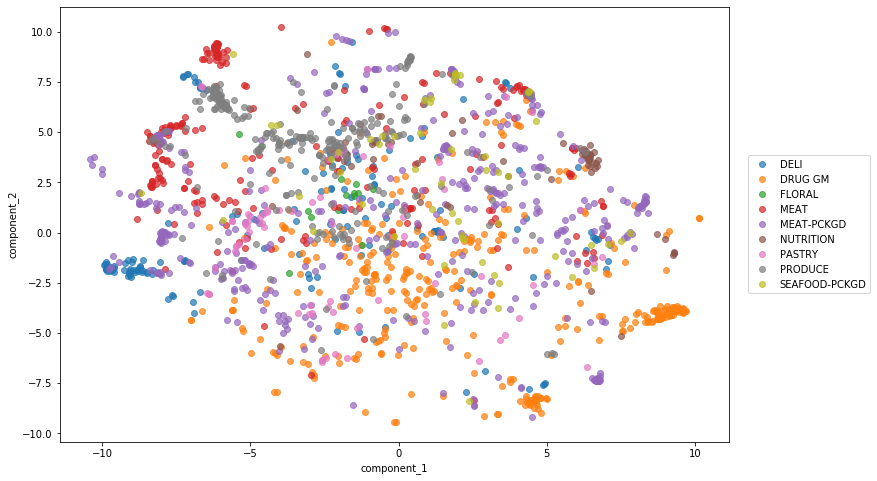

In [ ]:
display_components_in_2D_space(item_emb_tsne_reduced[item_emb_tsne_reduced['category'].isin(categories_with_own_items)], 
                               labels='category')

In [33]:
item_features[item_features['item_id']==1004906]

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
26869,1004906,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB


In [34]:
similar_items = model.similar_items(itemid_to_id[1004906], N=50)
similar_items = [id_to_itemid[sim[0]] for sim in similar_items]
similar_items.append(1004906)

In [35]:
item_emb_tsne[item_emb_tsne['item_id'] == 1004906]

,component_1,component_2,category,item_id
2427,-2.623801,2.577309,PRODUCE,1004906


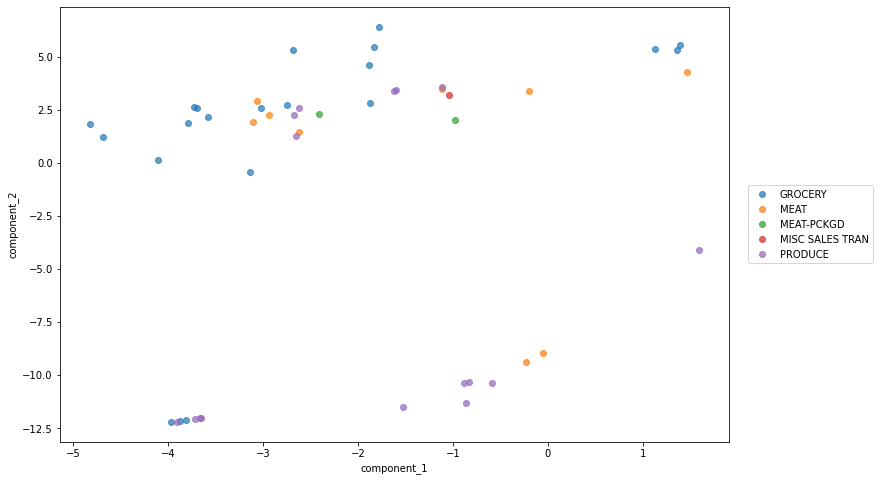

In [36]:
display_components_in_2D_space(item_emb_tsne[item_emb_tsne['item_id'].isin(similar_items)], 
                               labels='category')

Берем топ-5 популярных покупок юзера --> находим по 1 наиболее близкому товару СТМ для них --> рекомендуем

In [37]:
# your_code

popularity = data_train.groupby(['user_id', 'item_id'])['quantity'].count().reset_index()
popularity.sort_values('quantity', ascending=False, inplace=True)

popularity = popularity[popularity['item_id'] != 999999]

popularity = popularity.groupby('user_id').head(5)

popularity.sort_values('user_id', ascending=False, inplace=True)
popularity.head(2)

,user_id,item_id,quantity
709114,2500,859237,16
709374,2500,1082185,23


In [38]:
%%time

def get_rec(model, x):
    recs = model.similar_items(itemid_to_id[x], N=2)
    top_rec = recs[1][0]
    return id_to_itemid[top_rec]
    

popularity['similar_recommendation'] = popularity['item_id'].apply(lambda x: get_rec(model, x))
popularity.head(3)

CPU times: user 2.52 s, sys: 1.79 s, total: 4.3 s
Wall time: 2.24 s


In [39]:
recommendation_similar_items = popularity.groupby('user_id')['similar_recommendation'].unique().reset_index()
recommendation_similar_items.columns=['user_id', 'similar_recommendation']
recommendation_similar_items.head(2)

,user_id,similar_recommendation
0,1,"[826249, 1124432, 1082185, 927783, 999999]"
1,2,"[985999, 1133018, 8090509, 5569845, 1106523]"


In [40]:
result = result.merge(recommendation_similar_items, on='user_id', how='left')
result.head(2)

,user_id,actual,bm25,similar_recommendation
0,1,"[879517, 934369, 1115576, 1124029, 5572301, 65...","[1004390, 819518, 999391, 1047619, 958046]","[826249, 1124432, 1082185, 927783, 999999]"
1,3,"[823704, 834117, 840244, 913785, 917816, 93870...","[1110244, 8090521, 8090537, 941741, 5569230]","[1133018, 1075979, 1076875, 1092026, 942525]"


In [44]:
result.head(2)

,user_id,actual,bm25,similar_recommendation
0,1,"[879517, 934369, 1115576, 1124029, 5572301, 65...","[1004390, 819518, 999391, 1047619, 958046]","[826249, 1124432, 1082185, 927783, 999999]"
1,3,"[823704, 834117, 840244, 913785, 917816, 93870...","[1110244, 8090521, 8090537, 941741, 5569230]","[1133018, 1075979, 1076875, 1092026, 942525]"


In [41]:
%load_ext autoreload

In [57]:
result.apply(lambda row: precision_at_k(row['similar_recommendation'], row['actual']), axis=1).mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  


0.07905121746431576

### Кейс 2. Вашим друзьям нравится / Похожим пользователям нравится / ...

Пользователь --> похожих пользовтелей --> рекомендовать те товары, которые купили похожие юзеры

In [48]:
userid_to_id[10]

9

In [49]:
model.similar_users(userid_to_id[10], N=6)

[(9, 0.99999994),
 (664, 0.74967),
 (1549, 0.73471636),
 (1664, 0.71489066),
 (625, 0.6965738),
 (1539, 0.6931311)]

In [50]:
%%time

own = ItemItemRecommender(K=1, num_threads=4) # K - кол-во билжайших соседей

own.fit(csr_matrix(user_item_matrix).T.tocsr(), 
          show_progress=True)

recs = model.recommend(userid=userid_to_id[1], 
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=False)

  0%|          | 0/5001 [00:00<?, ?it/s]

CPU times: user 2.42 s, sys: 25.5 ms, total: 2.45 s
Wall time: 1.8 s


In [51]:
get_recommendations(user=1, model=own, N=1)

[856942]

In [ ]:
# your_code

-----

# Production

In [ ]:
def prefilter_items(data):
    # Уберем самые популярные товары (их и так купят)
    popularity = data_train.groupby('item_id')['user_id'].nunique().reset_index() / data_train['user_id'].nunique()
    popularity.rename(columns={'user_id': 'share_unique_users'}, inplace=True)
    
    top_popular = popularity[popularity['share_unique_users'] > 0.5].item_id.tolist()
    data = data[~data['item_id'].isin(top_popular)]
    
    # Уберем самые НЕ популярные товары (их и так НЕ купят)
    top_notpopular = popularity[popularity['share_unique_users'] < 0.01].item_id.tolist()
    data = data[~data['item_id'].isin(top_notpopular)]
    
    # Уберем товары, которые не продавались за последние 12 месяцев
    
    # Уберем не интересные для рекоммендаций категории (department)
    
    # Уберем слишком дешевые товары (на них не заработаем). 1 покупка из рассылок стоит 60 руб. 
    
    # Уберем слишком дорогие товарыs
    
    # ...
    
def postfilter_items(user_id, recommednations):
    pass

In [52]:
def get_recommendations(user, model, sparse_user_item, N=5):
    """Рекомендуем топ-N товаров"""
    
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]],  # !!! 
                                    recalculate_user=True)]
    return res

In [ ]:
def get_similar_items_recommendation(user, model, N=5):
    """Рекомендуем товары, похожие на топ-N купленных юзером товаров"""
    
    # your_code
    
    return res

In [ ]:
def get_similar_users_recommendation(user, model, N=5):
    """Рекомендуем топ-N товаров, среди купленных похожими юзерами"""
    
    # your_code
    
    return res

Все эти функции отправим затем в *src.**

----